In [ ]:
import sys
import os

sys.path.append(os.path.abspath(".."))  # Add parent folder to path

from funcoes import cria_grafo

In [ ]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)

import networkx as nx
from geopy.distance import geodesic  
from tqdm import tqdm
import pickle


rotas = pd.read_parquet("../dados/rotaaas_historico.parquet")
viagens = pd.read_parquet("../dados/viagens_historico.parquet")
estacoes_metro_e_trem = pd.read_parquet("../dados/estacoes_metro_e_trem.parquet")
paradas=pd.read_parquet("../dados/paradas_historico.parquet")
passageiros=pd.read_parquet("../dados\passageiros_unificado.parquet")

gdf = gpd.read_parquet("../dados/setores_censitarios_2022.parquet")

df_zonas=pd.read_excel("../dados/tabela_regioes_sp.xlsx")
gdf_sp = gdf[gdf["NM_MUN"] == "São Paulo"].merge(df_zonas,left_on='NM_DIST',right_on='Distritos')


rotas['data_referencia']=pd.to_datetime(rotas['data_referencia'],format="%Y%m").dt.to_period('M')
viagens['data_referencia']=pd.to_datetime(viagens['data_referencia'],format="%Y%m").dt.to_period('M')
paradas['data_referencia']=pd.to_datetime(paradas['data_referencia'],format="%Y%m").dt.to_period('M')
passageiros['data']=passageiros['data'].dt.to_period('M')

passageiros=passageiros.groupby(["data",'route_id']).sum().reset_index()


# Linhas que eram próximas ao metrô Butantã antes da inaguração da Vila Sônia

In [124]:
df_paradas_vila_sonia=paradas[(paradas.nome_estacao_mais_proxima=='VILA SÔNIA')]
viagens_vila_sonia=viagens.merge(df_paradas_vila_sonia,on=['stop_id', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon',
       'data_referencia',],how='inner')
rotas_oeste=viagens_vila_sonia[viagens_vila_sonia['Regiões']=='Oeste'].route_id.drop_duplicates().to_list()

# Calcula distância percorrida por cada rota

In [ ]:
import pandas as pd
from geopy.distance import geodesic

def max_geodesic_distance(coord_series):
    """
    Given a list of (latitude, longitude) tuples,
    returns the maximum geodesic distance (in kilometers) between any two points.
    """
    coords = list(coord_series)  # ensure it's a list
    max_dist = 0
    n = len(coords)

    for i in range(n):
        for j in range(i + 1, n):
            dist = geodesic(coords[i], coords[j]).kilometers
            if dist > max_dist:
                max_dist = dist

    return max_dist

# Supondo que você tenha a lista de rotas
rotas_filtradas = viagens[viagens['route_id'].isin(rotas_oeste)]
rotas_filtradas=rotas_filtradas[rotas_filtradas.direction_id==0]

rotas_filtradas['lat_lon']=list(zip(rotas_filtradas['stop_lat'], rotas_filtradas['stop_lon']))

rotas_distkm = (
    rotas_filtradas
    .groupby(['route_id','data_referencia'])
    .agg(
        dist_km=('lat_lon', max_geodesic_distance),
    )
    .reset_index()
    # .merge(rotas_filtradas[['stop_sequence','route_id','data_referencia','lat_lon']].rename(columns={"stop_sequence":"first_stop","lat_lon":"first_stop_coord"}),on=['first_stop','route_id','data_referencia'])
    # .merge(rotas_filtradas[['stop_sequence','route_id','data_referencia','lat_lon']].rename(columns={"stop_sequence":"last_stop","lat_lon":"last_stop_coord"}),on=['last_stop','route_id','data_referencia'])

)
rotas_distkm = (
    rotas_distkm
    .groupby(['route_id'])
    .agg(
        min_dist_km=('dist_km', 'min'),
        max_dist_km=('dist_km', 'max')
    ).reset_index())

rotas_distkm=rotas_distkm[rotas_distkm.min_dist_km!=0]
rotas_distkm['dist_km']=rotas_distkm['max_dist_km']-rotas_distkm['min_dist_km']
rotas_distkm=rotas_distkm.sort_values("dist_km",ascending=False)

rotas_distkm=rotas_distkm[(rotas_distkm.dist_km>1)&(~rotas_distkm.route_id.str.contains("METRÔ"))].merge(rotas[['route_long_name','route_id']],on='route_id').drop_duplicates()

In [166]:
display(rotas_distkm)

,route_id,min_dist_km,max_dist_km,dist_km,route_long_name
0,745810,6.022729,17.115659,11.092930,Jd. Boa Vista - Estação Da Luz
22,745810,6.022729,17.115659,11.092930,Jd. Boa Vista - Est. Da Luz
89,745810,6.022729,17.115659,11.092930,Jd. Boa Vista - Term. Vl. Sônia
123,701310,5.573380,10.405826,4.832446,Pq. Arariba - Pinheiros
212,701310,5.573380,10.405826,4.832446,Pq. Arariba - Term. Vl. Sônia
246,807710,6.138100,9.692414,3.554314,Jd. João Xxiii - Metrô Butantã
295,807710,6.138100,9.692414,3.554314,Jd. João Xxiii - Term. Morumbi
335,807710,6.138100,9.692414,3.554314,Jd. João Xxiii - Term. Vl. Sônia
369,807310,3.285426,6.738361,3.452936,Jardim Guaraú - Butantã
391,807310,3.285426,6.738361,3.452936,Jd. Guaraú - Butantã


In [218]:
rotas_filtradas=rotas_distkm.route_id.drop_duplicates().to_list()
anos=rotas[(rotas.data_referencia>='2021-01-01')&(rotas.data_referencia<='2023-01-01')].data_referencia.drop_duplicates().to_list()

# Animação com as rotas que atualmente são próximas da Vila Sônia

In [ ]:
from shapely import wkb

estacoes_metro_e_trem.columns
vila_sonia_e_butantan=estacoes_metro_e_trem[estacoes_metro_e_trem.nm_estacao_metro_trem.isin(["BUTANTÃ",'VILA SÔNIA'])]
vila_sonia_e_butantan=vila_sonia_e_butantan[vila_sonia_e_butantan.existencia=='atual']

# Se a geometria estiver como WKB (tipo bytes), converta assim:
vila_sonia_e_butantan["geometry"] = vila_sonia_e_butantan["geometry"].apply(wkb.loads)
vila_sonia_e_butantan = gpd.GeoDataFrame(vila_sonia_e_butantan, geometry="geometry", crs="EPSG:4326")

Index(['id', 'cd_identificador', 'cd_identificador_empresa_metro_trem',
       'nm_estacao_metro_trem', 'cd_situacao_estacao_metro_trem',
       'sg_fonte_original', 'cd_identificador_linha', 'tx_situacao_metro_trem',
       'nm_linha_metro_trem', 'nm_empresa_metro_trem', 'cd_tipo_transporte',
       'geometry', 'tipo', 'existencia', 'sg_estacao_metro_trem'],
      dtype='object')

Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 285.70it/s]

2021-01 - Grafo final: 20070 nós e 566 arestas


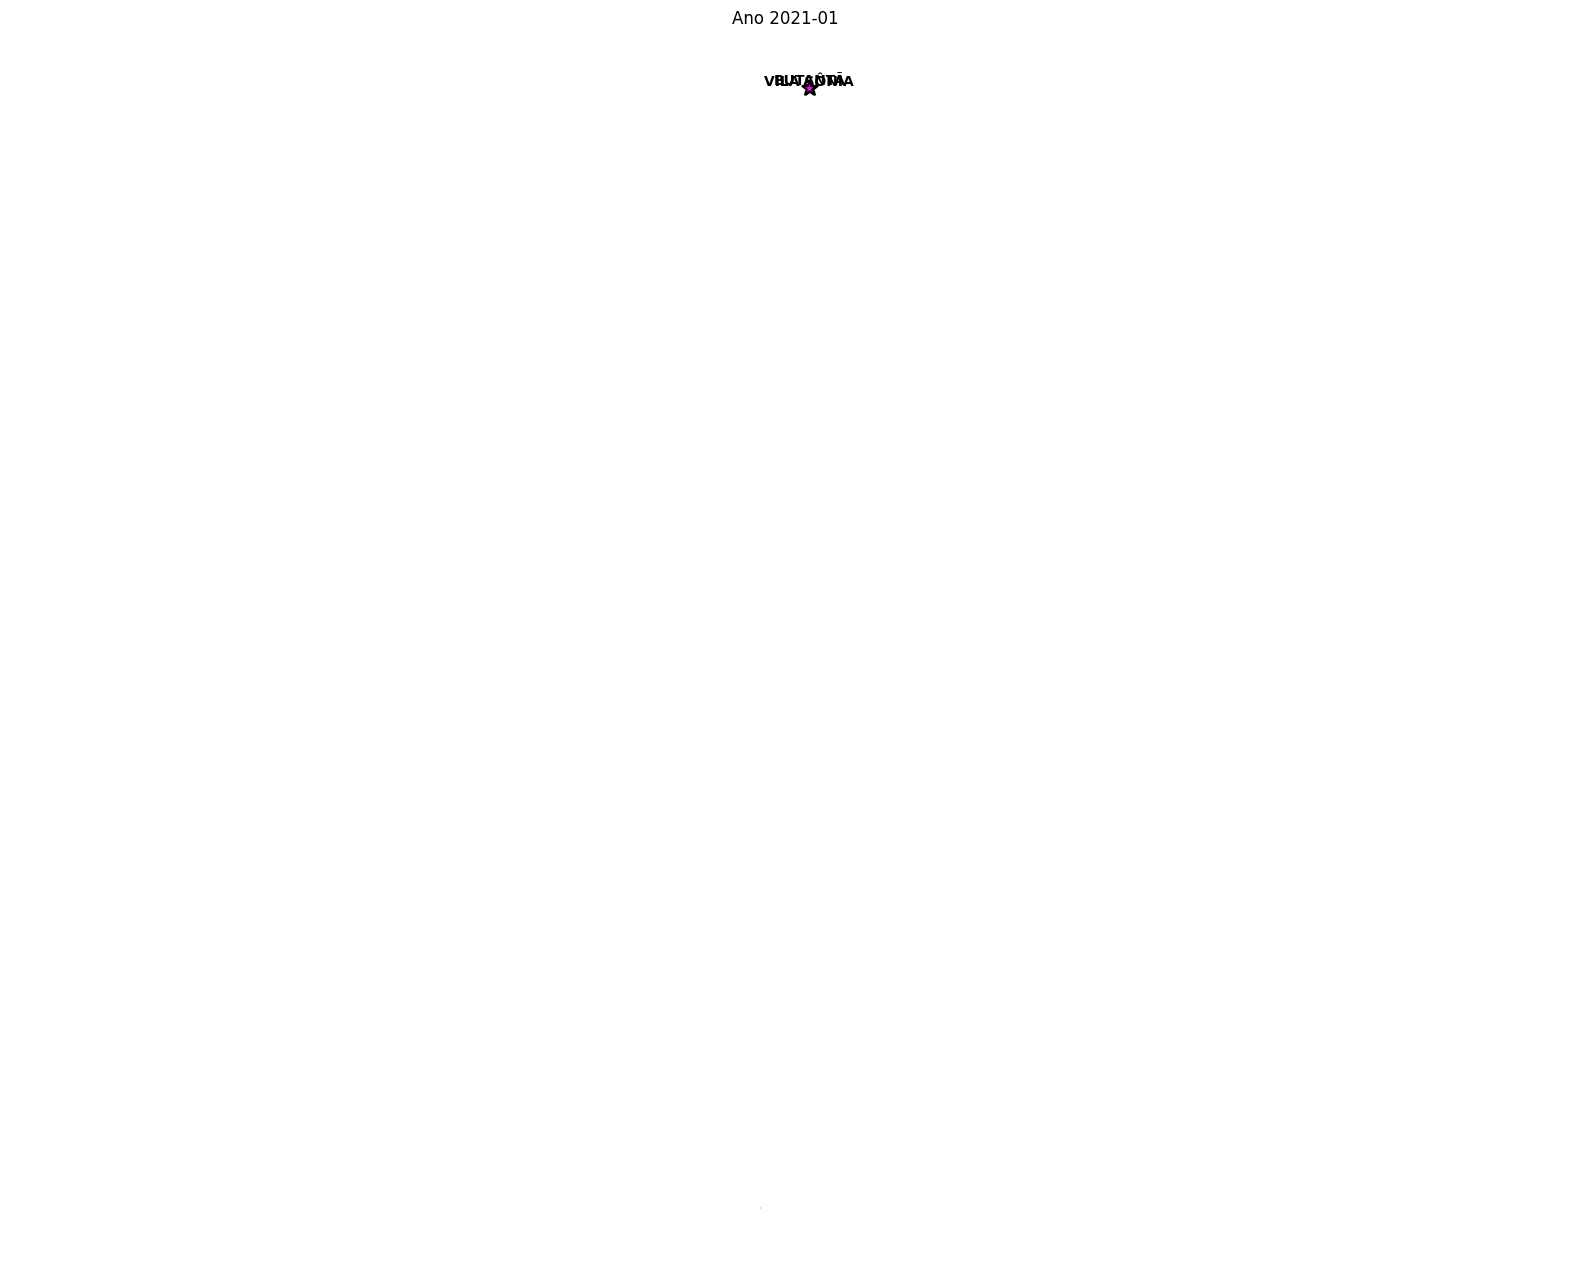

Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 293.20it/s]

2021-01 - Grafo final: 20070 nós e 566 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 290.77it/s]

2021-02 - Grafo final: 20073 nós e 567 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 301.36it/s]

2021-03 - Grafo final: 20068 nós e 569 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 291.51it/s]

2021-04 - Grafo final: 20076 nós e 568 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 283.14it/s]

2021-05 - Grafo final: 20088 nós e 566 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 305.42it/s]

2021-06 - Grafo final: 20084 nós e 566 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 274.88it/s]

2021-07 - Grafo final: 20094 nós e 566 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 285.73it/s]

2021-08 - Grafo final: 20093 nós e 567 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 293.21it/s]

2021-09 - Grafo final: 20073 nós e 567 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 278.48it/s]

2021-10 - Grafo final: 20088 nós e 567 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 289.34it/s]

2021-11 - Grafo final: 20099 nós e 567 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 285.71it/s]

2021-12 - Grafo final: 20125 nós e 568 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 289.35it/s]

2022-01 - Grafo final: 20127 nós e 568 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 293.34it/s]

2022-02 - Grafo final: 20121 nós e 568 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 289.35it/s]

2022-03 - Grafo final: 20121 nós e 565 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 289.35it/s]

2022-04 - Grafo final: 20192 nós e 569 arestas


Adicionando arestas entre paradas...


100%|██████████| 22/22 [00:00<00:00, 271.59it/s]

2022-05 - Grafo final: 20201 nós e 571 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 315.78it/s]

2022-06 - Grafo final: 20223 nós e 519 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 337.87it/s]

2022-07 - Grafo final: 20217 nós e 521 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 313.85it/s]

2022-08 - Grafo final: 20268 nós e 521 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 338.03it/s]

2022-09 - Grafo final: 20277 nós e 521 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 338.02it/s]

2022-10 - Grafo final: 20296 nós e 522 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 333.19it/s]

2022-11 - Grafo final: 20305 nós e 522 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 324.33it/s]

2022-12 - Grafo final: 20323 nós e 524 arestas


Adicionando arestas entre paradas...


100%|██████████| 24/24 [00:00<00:00, 337.87it/s]

2023-01 - Grafo final: 20363 nós e 526 arestas


In [248]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.animation as animation
import geopandas as gpd
import numpy as np

fig, ax = plt.subplots(figsize=(20, 16))

def update(i):
    ax.clear()

    # Plotar fundo geográfico
    gdf_sp.plot(ax=ax, color="whitesmoke", edgecolor="lightgray", linewidth=0.3)

    # Carrega grafo
    G = cria_grafo(anos[i],rotas[rotas.route_id.isin(rotas_filtradas)],passageiros[passageiros.route_id.isin(rotas_filtradas)],viagens[viagens.route_id.isin(rotas_filtradas)],paradas,estacoes_metro_e_trem)

    # Para cada aresta, pega as coordenadas e plota uma linha
    for u, v, data in G.edges(data=True):
        try:
            lat_u = G.nodes[u]['latitude']
            lon_u = G.nodes[u]['longitude']
            lat_v = G.nodes[v]['latitude']
            lon_v = G.nodes[v]['longitude']

            ax.plot([lon_u, lon_v], [lat_u, lat_v], color="#FF671F", alpha=0.6, linewidth=1)

        except KeyError:
            # Se algum nó não tiver coordenadas, pula
            continue
    
    coords = vila_sonia_e_butantan.geometry.apply(lambda p: (p.x, p.y))
    xs, ys = zip(*coords)
    ax.scatter(xs, ys, color='magenta', s=120, marker='*', edgecolor='black', linewidth=1.5, zorder=5)
    for x, y, nome in zip(xs, ys, vila_sonia_e_butantan["nm_estacao_metro_trem"]):
        ax.text(x, y, nome, fontsize=10, color='black', ha='center', va='bottom', weight='bold')

    ax.set_title(f"Ano {anos[i]}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis('equal')

    # Título
    ax.set_title(f"Ano {anos[i]}")
    ax.axis("off")
    plt.show()

# Salva animação
ani = animation.FuncAnimation(fig, update, frames=len(anos), repeat=False)
ani.save(f"Rotas impactadas pela estação Vila Sônia.gif", writer="pillow")

# Quantidade de passageiros nas linhas alteradas

In [249]:
passageiros_filtrado=passageiros[passageiros.route_id.isin(rotas_filtradas)]
passageiros_filtrado=passageiros_filtrado[passageiros_filtrado.data<="2025-03-31"]
df_pivot = passageiros_filtrado.pivot_table(index='data', columns='route_id', values='passageiros_total', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()
df_pivot.index = df_pivot.index.to_timestamp()

df_pivot

route_id,701310,714C10,745810,771P10,801810,802310,802510,802610,807210,807310,807521,807710,809J10,809L10,857P21,870022
data,,,,,,,,,,,,,,,,
2015-01-01,160338.0,86120.0,213637.0,75204.0,65268.0,47722.0,80254.0,75328.0,235440.0,100893.0,0.0,52819.0,66433.0,246569.0,4503.0,0.0
2015-02-01,142048.0,85260.0,219061.0,71771.0,67182.0,47187.0,71757.0,73269.0,226671.0,93176.0,0.0,52369.0,68862.0,230563.0,5108.0,5141.0
2015-03-01,177148.0,100684.0,255067.0,81777.0,77330.0,56450.0,83461.0,86683.0,276277.0,106489.0,0.0,64229.0,80540.0,277022.0,6652.0,7127.0
2015-04-01,176280.0,96111.0,243871.0,77186.0,75526.0,51868.0,78741.0,76007.0,268396.0,113109.0,0.0,58340.0,76898.0,264908.0,6191.0,6072.0
2015-05-01,177865.0,97196.0,251976.0,80368.0,78452.0,53765.0,83671.0,79729.0,279804.0,117470.0,0.0,57860.0,79464.0,273838.0,6000.0,7762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,109714.0,72138.0,109128.0,68635.0,27044.0,51562.0,73524.0,84708.0,92853.0,76895.0,50592.0,54292.0,27233.0,237779.0,0.0,0.0
2024-12-01,148714.0,98528.0,154031.0,95007.0,35644.0,69856.0,100432.0,113165.0,128813.0,103474.0,72488.0,69737.0,35413.0,315250.0,447.0,0.0
2025-01-01,100913.0,67316.0,120918.0,65966.0,25199.0,49887.0,66734.0,81337.0,90758.0,73788.0,58475.0,48183.0,25193.0,228509.0,77.0,0.0


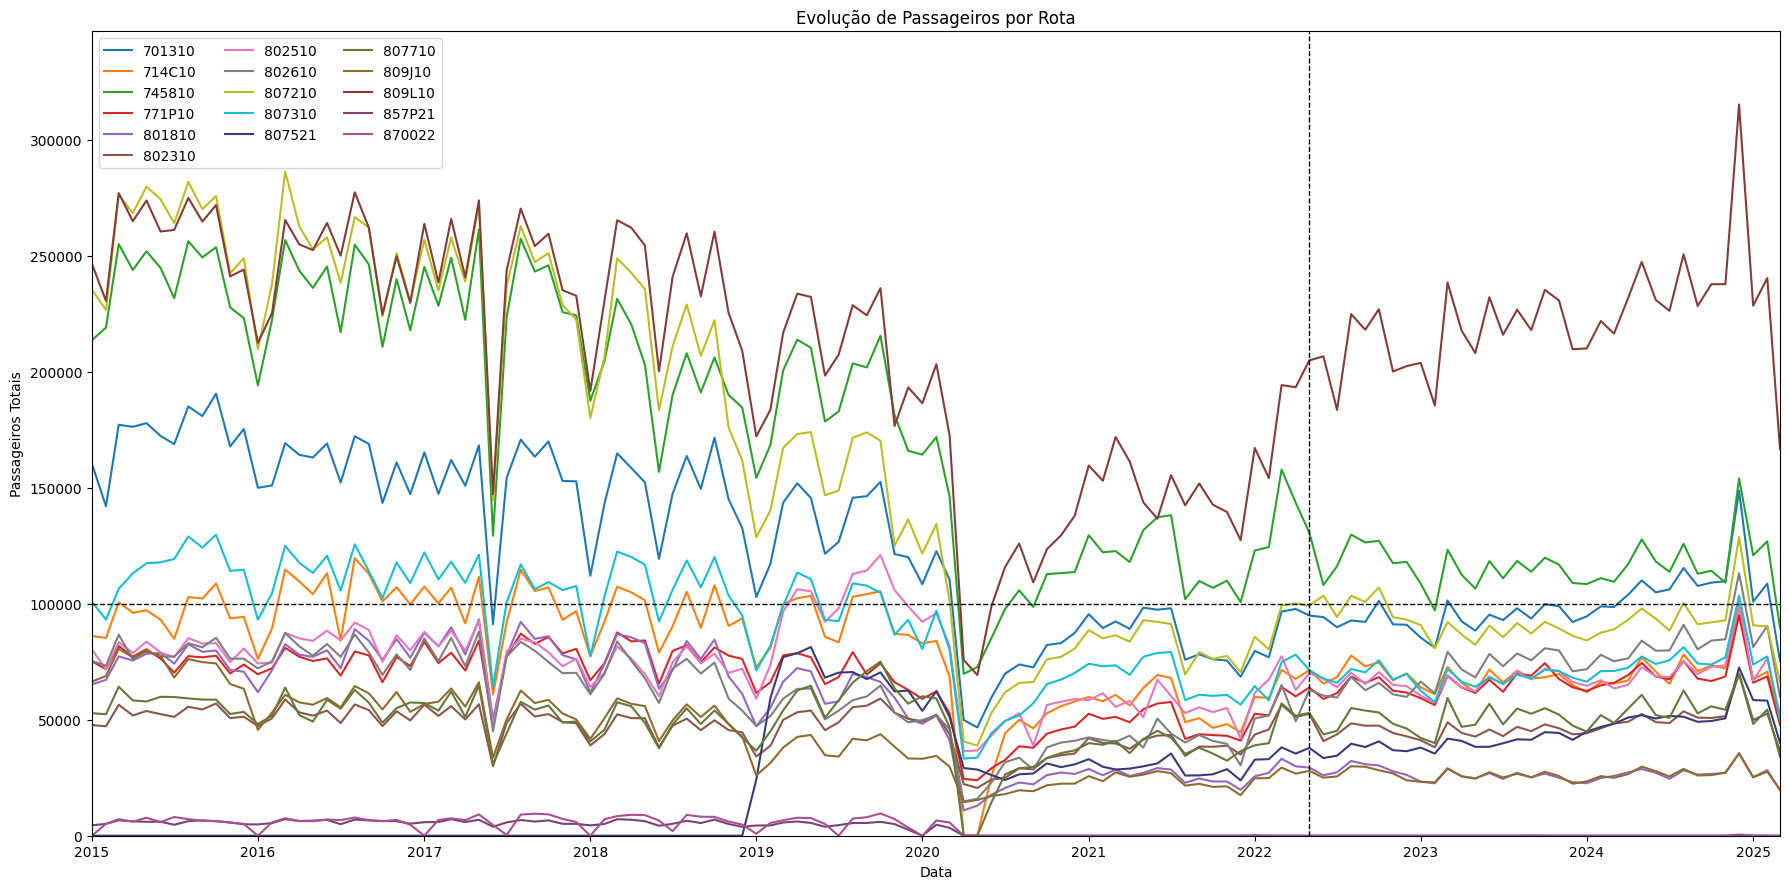

In [224]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
    "#a55194", "#6b6ecf", "#9c9ede", "#ce6dbd", "#de9ed6"
]

fig, ax = plt.subplots(figsize=(18, 9))

# Aplica as cores, repetindo se houver mais que 20 rotas
for i, route in enumerate(df_pivot.columns):
    ax.plot(
        df_pivot.index.to_pydatetime(),
        df_pivot[route],
        label=route,
        color=colors[i % len(colors)]
    )

ax.set_xlim(df_pivot.index.min().to_pydatetime(), df_pivot.index.max().to_pydatetime())
ax.set_ylim(0, df_pivot.values.max() * 1.1)
ax.set_title('Evolução de Passageiros por Rota')
ax.set_xlabel('Data')
ax.set_ylabel('Passageiros Totais')

# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)

# Legenda em duas colunas para melhor ajuste
ax.legend(ncol=3)

plt.tight_layout()
plt.savefig("Passageiros.png")
plt.show()


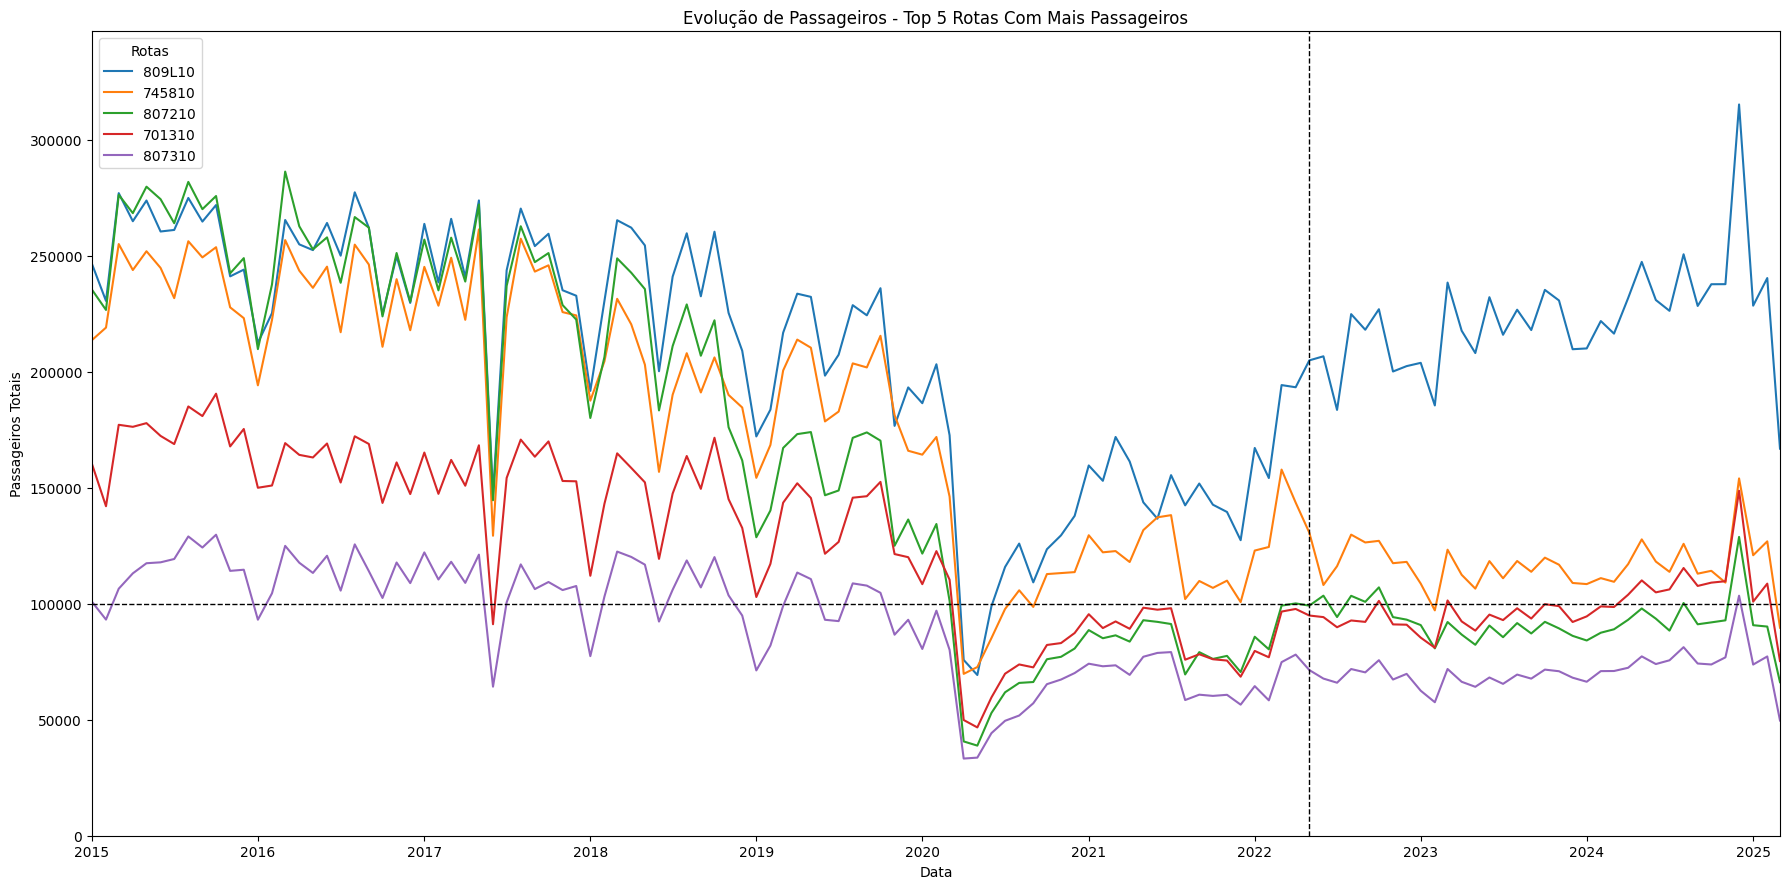

In [222]:
top_5_routes = df_pivot.sum().sort_values(ascending=False).head(5).index

fig, ax = plt.subplots(figsize=(18, 9))

# Plota apenas as top 5 rotas
for i, route in enumerate(top_5_routes):
    ax.plot(
        df_pivot.index.to_pydatetime(),
        df_pivot[route],
        label=route,
        color=colors[i]
    )

ax.set_xlim(df_pivot.index.min().to_pydatetime(), df_pivot.index.max().to_pydatetime())
ax.set_ylim(0, df_pivot[top_5_routes].values.max() * 1.1)
ax.set_title('Evolução de Passageiros - Top 5 Rotas Com Mais Passageiros')
ax.set_xlabel('Data')
ax.set_ylabel('Passageiros Totais')

# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)

# Legenda ajustada
ax.legend(title="Rotas")

plt.tight_layout()
plt.savefig("Passageiros - Top 5.png")
plt.show()


## Rotas mais afetadas (745810 e 701310)

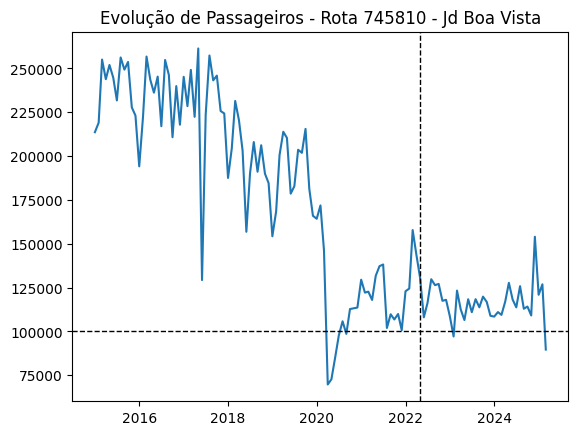

In [225]:
fig, ax = plt.subplots()
route = '745810'
ax.plot(df_pivot.index.to_pydatetime(), df_pivot[route])
ax.set_title('Evolução de Passageiros - Rota 745810 - Jd Boa Vista')
# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)
plt.savefig("Passageiros rota 745810 - Jd Boa Vista.png")
plt.show()


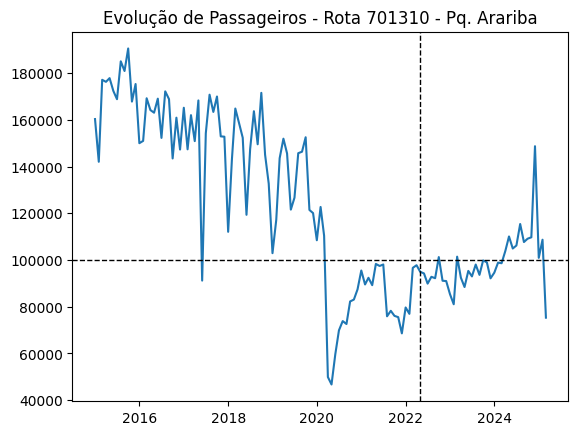

In [227]:
fig, ax = plt.subplots()
route = '701310'
ax.plot(df_pivot.index.to_pydatetime(), df_pivot[route])
ax.set_title('Evolução de Passageiros - Rota 701310 - Pq. Arariba')
# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)
plt.savefig("Passageiros rota 701310 - Pq. Arariba.png")
plt.show()


# Apenas dias da semana

In [254]:
import numpy as np
import holidays  # biblioteca útil para feriados

passageiros=pd.read_parquet("../dados\passageiros_unificado.parquet")

# Define feriados nacionais brasileiros
br_feriados = holidays.Brazil()

# Filtro: dia da semana (0=segunda, ..., 4=sexta) E não feriado
dias_uteis = (
    (passageiros["data"].dt.weekday < 5) &  # Segunda a sexta
    (~passageiros["data"].isin(br_feriados))  # Não é feriado
)

# Aplica o filtro
passageiros_uteis = passageiros[dias_uteis]
passageiros_uteis['data']=passageiros_uteis['data'].dt.to_period('M')
passageiros_uteis=passageiros_uteis.groupby(["data",'route_id']).sum().reset_index()


C:\Users\franc\AppData\Local\Temp\ipykernel_2804\1724811222.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [255]:

passageiros_uteis_filtrado=passageiros_uteis[passageiros_uteis.route_id.isin(rotas_filtradas)]
passageiros_uteis_filtrado=passageiros_uteis_filtrado[passageiros_uteis_filtrado.data<="2025-03-31"]
df_pivot = passageiros_uteis_filtrado.pivot_table(index='data', columns='route_id', values='passageiros_total', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()
df_pivot.index = df_pivot.index.to_timestamp()

df_pivot

route_id,701310,714C10,745810,771P10,801810,802310,802510,802610,807210,807310,807521,807710,809J10,809L10,857P21,870022
data,,,,,,,,,,,,,,,,
2015-01-01,129169.0,74325.0,176127.0,61191.0,56801.0,40638.0,66466.0,65720.0,190938.0,79316.0,0.0,52727.0,58006.0,208317.0,4503.0,0.0
2015-02-01,112902.0,74049.0,183366.0,58926.0,59743.0,40913.0,59579.0,63937.0,186040.0,73108.0,0.0,52277.0,60528.0,191499.0,5108.0,5141.0
2015-03-01,144662.0,89313.0,213264.0,68670.0,69288.0,49418.0,70255.0,77523.0,229445.0,86332.0,0.0,64154.0,71749.0,233651.0,6652.0,7058.0
2015-04-01,145905.0,85047.0,206601.0,64625.0,67648.0,45460.0,67378.0,68209.0,226922.0,93124.0,0.0,58271.0,69041.0,226264.0,6191.0,6072.0
2015-05-01,140959.0,82421.0,205009.0,64869.0,68933.0,45444.0,67836.0,69245.0,226995.0,91066.0,0.0,57781.0,69207.0,225476.0,6000.0,7762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,80916.0,55873.0,82460.0,50857.0,20840.0,39127.0,54610.0,64911.0,68632.0,57572.0,35567.0,45395.0,21321.0,183126.0,0.0,0.0
2024-12-01,112814.0,77123.0,119725.0,72263.0,28438.0,55279.0,76466.0,90089.0,97589.0,79766.0,52380.0,62830.0,28831.0,252246.0,447.0,0.0
2025-01-01,81610.0,61211.0,102787.0,53938.0,21621.0,42282.0,54784.0,70673.0,75883.0,60610.0,46986.0,48159.0,22126.0,199106.0,77.0,0.0


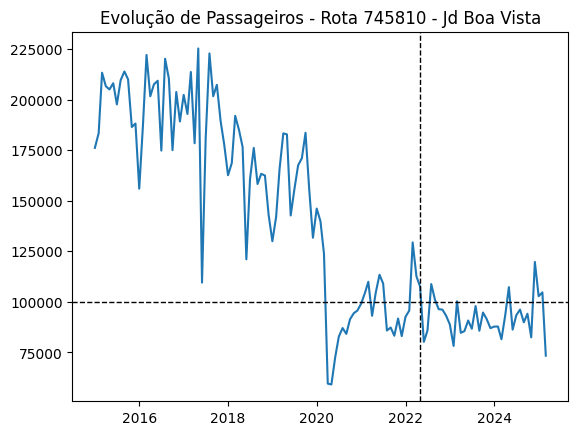

In [256]:
fig, ax = plt.subplots()
route = '745810'
ax.plot(df_pivot.index.to_pydatetime(), df_pivot[route])
ax.set_title('Evolução de Passageiros - Rota 745810 - Jd Boa Vista')
# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)
plt.savefig("Passageiros dias úteis rota 745810 - Jd Boa Vista.png")
plt.show()

In [264]:
frequencies=pd.read_csv(r"..\dados\GTFS_202503\frequencies.txt")
frequencies[frequencies.trip_id.str.contains("7458")]

,trip_id,start_time,end_time,headway_secs
28743,7458-10-0,00:00:00,00:59:00,1800
28744,7458-10-0,04:00:00,04:59:00,1800
28745,7458-10-0,05:00:00,05:59:00,1200
28746,7458-10-0,06:00:00,06:59:00,1200
28747,7458-10-0,07:00:00,07:59:00,1800
28748,7458-10-0,08:00:00,08:59:00,1800
28749,7458-10-0,09:00:00,09:59:00,1800
28750,7458-10-0,10:00:00,10:59:00,1800
28751,7458-10-0,11:00:00,11:59:00,1200
28752,7458-10-0,12:00:00,12:59:00,1200


In [ ]:
ids_inicio_rota_745810=viagens[(viagens.route_id=='745810')&(viagens.data_referencia=='2025-03')&(viagens.stop_sequence<12)&(viagens.direction_id==0)].stop_id.to_list()

In [301]:
print("Quantidade de passageiros que moram na região de início da linha 745810 (bairro Jd Boa Vista): ", paradas[paradas.stop_id.isin(ids_inicio_rota_745810)].drop_duplicates().v0001.sum())

Quantidade de passageiros que moram na região de início da linha 745810 (bairro Jd Boa Vista):  568961.0
